## Comparision of two sampling strategies

In this notebook we compare two sampling strategies for estimating true pole. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag

import smpsite as smp

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


## Setup 

Our goal is to estimate the paleomagnetic pole $\mu$ for a given period of time or age. For doing so, we are going to recollec a number $N_k$ samples from $K$ different sites, $k=1,2,\ldots,K$. For each site, consequence of secular variation, we are not observing directly $\mu$, but instead $\mu_k$ as a result of secular variations of the magnetic field. If we compute the Fisher mean $\hat \mu_k$ (the hat symbol will be used always for statistical inferences, in opposition to the _true_ value of the pole), then we hope that the new Fisher mean $\hat \mu$ of the $\hat \mu_k$s will give us a estimate for the paleomagnetic poles that will average out the secular variation. The question we are trying to address here is what is the best recollection design of the $N = N_1 + \ldots + N_K$ sample poles that will lead to a better estimation of the final paleomagnetic pole $\mu$. 

We are going to consider the following statistical model for how the sample poles are generated. 
$$
\mu_k \sim \text{Fisher}(\mu, \kappa_\text{secular}) \quad k=1,2,\ldots,K
$$
$$
x_{k,j} \sim \text{Fisher}(\mu_k, \kappa_\text{vgp}) \quad \text{with probability $1-p$ and } 
$$
$$
x_{k,j} \sim \text{Unif}(S^2) \quad \text{otherwise} \quad j=1,2,\ldots,N_k,
$$
where $\kappa_\text{secular}$ and $\kappa_\text{vgp}$ are the dispersion parameters of the Fisher distribution. The parameter $p$ has been added to quantify the effect of outliers in the sampling process. With probability $1-p$ we are going to observe a verical sample of the magnetic field, while with probability $p$ our sample will be corrupted and instead we will observe an spourious medition, modelled by an uniform distribution on the sphere, that is, no information at all about the orientation of the true field. 

We are going to compare two different strategies for estimating the paleomagnetic pole $\mu$:
- Method 1: Compute the Fisher mean of ALL the sample points afor each site and then compute a second Fisher mean of these site vgps to obtain a final estimation of the true paleomagnetic pole.
- Method 2: Assume we are perfectly able to detect outliers, so we can repeat Method 1 after removing those sample points that are clearly ourliers. 

Since we want to know what is the choice of $N_1, N_2, \ldots, N_K$ that will lead to the best estimation of the paleomagnetic pole, we are going to compare these two methods for different strategies. For example, if $N_k$ is large enought then we may be in the case where we can use Method 2, and then we will compare it with the performance of Method 1 when $N_1 = \ldots = N_K = 1$, for example.

## Simulation

We first set the parameter for the two simulations. We do this by defining an object class `Params` that has been implemented inside the package `smpsite`.

In [6]:
angular_dispersio_within_site = 10 # degrees
kappa_within_site = smp.angular2kappa(angular_dispersio_within_site)
latitude = 30
outlier_rate = 0.10
n_iters = 100

params1 = smp.Params(N=40,
                     n0=1,
                     kappa_within_site=kappa_within_site,
                     site_lat=latitude, 
                     site_long=0,
                     outlier_rate=outlier_rate,
                     secular_method="G",
                     kappa_secular=None)

params2 = smp.Params(N=8,
                     n0=5,
                     kappa_within_site=kappa_within_site,
                     site_lat=latitude, 
                     site_long=0,
                     outlier_rate=outlier_rate,
                     secular_method="G",
                     kappa_secular=None)

assert params1.N * params1.n0 == params2.N * params2.n0, "The two methods don't have the same number of total samples."

In [7]:
%%time

df_more_sites = smp.simulate_estimations(params1, n_iters=n_iters, ignore_outliers="vandamme")
df_less_sites = smp.simulate_estimations(params2, n_iters=n_iters, ignore_outliers="True")

CPU times: user 8.88 s, sys: 7.35 ms, total: 8.89 s
Wall time: 8.88 s


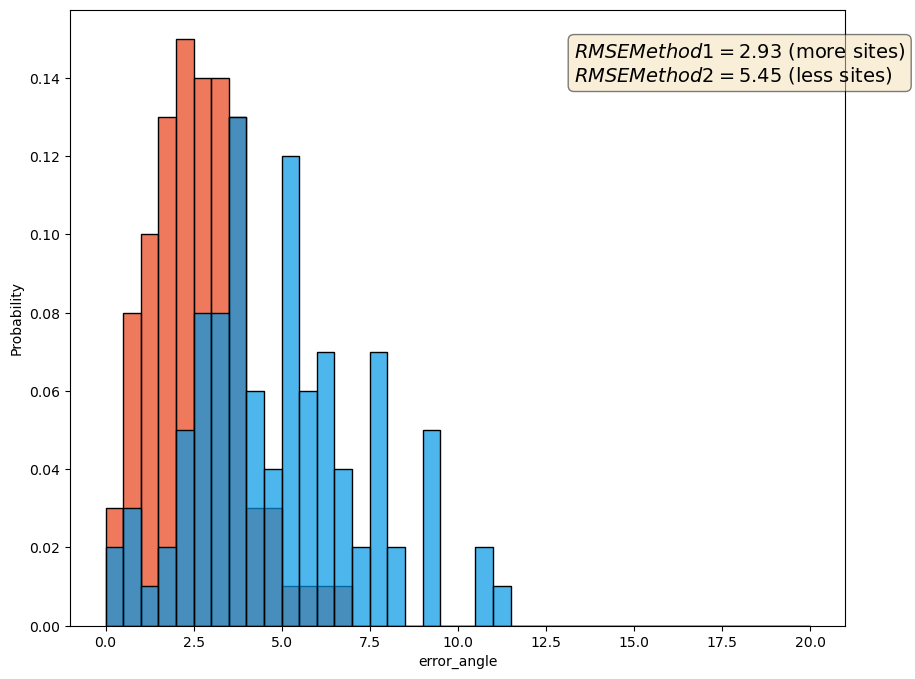

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

sns.histplot(df_more_sites.error_angle, ax=axes, color='#e84118', stat='probability', binwidth=.5, binrange=(0,20), alpha=.7)
sns.histplot(df_less_sites.error_angle, ax=axes, color='#0097e6', stat='probability', binwidth=.5, binrange=(0,20), alpha=.7)

textstr = '\n'.join((
r'$RMSE Method 1=%.2f$ (more sites)' % (np.mean(df_more_sites.error_angle**2)**.5, ),
r'$RMSE Method 2=%.2f$ (less sites)' % (np.mean(df_less_sites.error_angle**2)**.5, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
plt.text(0.65, 0.95, textstr, transform=axes.transAxes, fontsize=14,
        verticalalignment='top', bbox=props);